# Brain Tumor Segmentation

This project uses a Convolutional Neural Network (CNN) to analyse MRI brain scan images to indentify tumor regions and perform multiclass segmentation. The model is trained using a subset of the **BraTS2020** datset from Kaggle and is designed for deployment in clinical aid tools.

### Objective
To segment MRI images of the brain into:
- Background
- Enhancing
- non Enhancing
- Edema

We use **transfer learning with MobileNetV2** for efficient classification, aiming for both accuracy and lightweight deployment.

---

In [2]:
from pathlib import Path
import numpy as np
import cv2

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp

from tqdm import tqdm

### Clean data

Remove triplets with empty segmentation overlays in training data

In [3]:
root_dir = "/kaggle/input/brats-subset/sampled_pngs"

flair_dir = Path(root_dir) / "flair"
t1ce_dir  = Path(root_dir) / "t1ce"
seg_dir   = Path(root_dir) / "seg"

def parse_filename(fname: str):
    """
    Example: BraTS20_Training_001_flair_axial_32.png
    Returns: (pid, plane, slice)
    """
    parts = fname.split("_")
    pid = parts[2]   # '001'
    plane = parts[4] # 'axial', 'sagittal', or 'coronal'
    slice_idx = parts[5].replace(".png", "")
    return pid, plane, slice_idx

# Build lookup dictionaries
flair_map, t1ce_map, seg_map = {}, {}, {}

for f in flair_dir.glob("*.png"):
    pid, plane, sl = parse_filename(f.name)
    key = (pid, plane, sl)
    flair_map[key] = str(f)

for f in t1ce_dir.glob("*.png"):
    pid, plane, sl = parse_filename(f.name)
    key = (pid, plane, sl)
    t1ce_map[key] = str(f)

for f in seg_dir.glob("*.png"):
    pid, plane, sl = parse_filename(f.name)
    key = (pid, plane, sl)
    seg_map[key] = str(f)

# Collect triplets
triplets = []
for key in flair_map.keys():
    if key in t1ce_map and key in seg_map:
        triplets.append((flair_map[key], t1ce_map[key], seg_map[key]))

print(f"Total triplets found: {len(triplets)}")

Total triplets found: 37242


In [4]:
import random

# Split slices
labeled_slices = [t for t in triplets if cv2.imread(t[2], cv2.IMREAD_GRAYSCALE).max() > 0]
empty_slices = [t for t in triplets if cv2.imread(t[2], cv2.IMREAD_GRAYSCALE).max() == 0]

print(f"total items with empty seg masks: {len(empty_slices)}")

total items with empty seg masks: 14317


In [5]:
# Keep 10% of empty slices
keep_empty_frac = 0.1
kept_empty = random.sample(empty_slices, int(len(empty_slices) * keep_empty_frac))

# Final dataset
final_triplets = labeled_slices + kept_empty
random.shuffle(final_triplets)

print(f"Final dataset size: {len(final_triplets)}")

Final dataset size: 24356


## Dataset and Data Loaders

- Perform Image agumentation
- Randomly drop one channel to drop modality
- Randomly send same mosality in both channels

In [6]:
class ChannelDropout(A.ImageOnlyTransform):
    """
    Randomly zero one channel (simulate missing modality).
    Optionally collapse both channels to the same surviving channel
    to simulate inference with a single channel duplicated.
    """
    def __init__(self, p=0.5, collapse_prob=0.25, always_apply=False):
        super().__init__(always_apply, p)
        self.collapse_prob = collapse_prob

    def apply(self, img, **params):
        # img: H x W x C
        if img.ndim == 3 and img.shape[2] == 2:
            drop_ch = np.random.randint(0, 2)   # 0 or 1
            keep_ch = 1 - drop_ch
            img[:, :, drop_ch] = 0.0
            if np.random.rand() < self.collapse_prob:
                # collapse: duplicate keep_ch into drop_ch
                img[:, :, drop_ch] = img[:, :, keep_ch]
        return img


class BT_Dataset(Dataset):
    def __init__(self, triplets, img_size=256, augment=True, dropout=True, n_classes=4):
        self.triplets = triplets
        self.n_classes = n_classes
        self.mapping = {0: 0, 85: 1, 170: 2, 255: 3}   # <-- adjust to your actual PNG values

        transforms_list = [
            A.Resize(img_size, img_size)
        ]
        if augment:
            transforms_list.extend([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.2),
                A.RandomRotate90(p=0.5),
               A.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                         scale=(0.9, 1.1),
                         rotate=(-15, 15),
                         p=0.5),
                        ])
        if dropout:
            transforms_list.append(ChannelDropout(p=0.5, collapse_prob=0.25))

        transforms_list.extend([
            A.Normalize(mean=(0, 0), std=(1, 1)),
            ToTensorV2()
        ])

        self.transform = A.Compose(transforms_list)


    def remap_mask_values(self, mask):
        """
        Remap pixel values in the mask image to class IDs.
        Example mapping: {0:0, 85:1, 170:2, 255:3}
        """
        mask_out = np.zeros_like(mask, dtype=np.int64)
        for k, v in self.mapping.items():
            mask_out[mask == k] = v
        return mask_out

    
    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        flair_path, t1ce_path, seg_path = self.triplets[idx]

        flair = cv2.imread(flair_path, cv2.IMREAD_GRAYSCALE).astype('float32')
        t1ce  = cv2.imread(t1ce_path, cv2.IMREAD_GRAYSCALE).astype('float32')
        seg   = cv2.imread(seg_path, cv2.IMREAD_GRAYSCALE).astype('int64')

        seg   = self.remap_mask_values(seg)  # <-- here

        img = np.stack([flair, t1ce], axis=-1)   # HxWx2

        transformed = self.transform(image=img, mask=seg)
        img_tensor = transformed['image']        # (C,H,W)
        mask_tensor = transformed['mask'].long() # (H,W) integer IDs

        return img_tensor, mask_tensor


In [7]:
dataset = BT_Dataset(triplets, img_size=256, augment=True, dropout=True)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32,num_workers=4,shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, num_workers=4, shuffle=False)

imgs, masks = next(iter(train_loader))
print(imgs.shape)   # [B, 2, H, W]
print(masks.shape)  # [B, H, W]

torch.Size([32, 2, 256, 256])
torch.Size([32, 256, 256])


In [8]:
# pick device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load modal

- Architecture: Unet
- Encoder : Efficientnet-B0

In [9]:
n_classes = 4  # adjust to however many classes your mask uses

model = smp.Unet(
    encoder_name='timm-efficientnet-b0',
    encoder_weights='imagenet',
    in_channels=2,     # FLAIR + T1CE
    classes=n_classes   # multi-class
    # output
).to(device)

config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

## Metrics

- Loss fucntion : weighted CrossEntropy + Dice Loss
- Performace Metric : Multiclass IOU score

In [10]:
ce_loss = nn.CrossEntropyLoss()  # expects raw logits [B, C, H, W] and targets [B, H, W]

def multiclass_dice_loss(logits, targets, eps=1e-6):
    """Compute mean Dice loss across classes (excluding background if desired)."""
    probs = torch.softmax(logits, dim=1)   # [B, C, H, W]
    targets_one_hot = torch.nn.functional.one_hot(targets, num_classes=logits.shape[1]) # [B, H, W, C]
    targets_one_hot = targets_one_hot.permute(0, 3, 1, 2).float()                       # [B, C, H, W]
    dims = (0,2,3)
    intersection = torch.sum(probs * targets_one_hot, dims)
    cardinality = torch.sum(probs + targets_one_hot, dims)
    dice_per_class = (2. * intersection + eps) / (cardinality + eps)
    return 1 - dice_per_class.mean()

def lossfn(logits, masks):
    return 0.5 * ce_loss(logits, masks) + 0.5 * multiclass_dice_loss(logits, masks)

In [11]:
@torch.no_grad()
def compute_mean_iou(logits, targets, eps=1e-6):
    preds = torch.argmax(logits, dim=1)       # [B, H, W]
    ious = []
    for c in range(logits.shape[1]):          # per class
        inter = ((preds == c) & (targets == c)).sum().float()
        union = ((preds == c) | (targets == c)).sum().float()
        if union > 0:
            ious.append((inter + eps) / (union + eps))
    return torch.stack(ious).mean().item() if ious else 0.0

In [12]:
def train_model(
    model, 
    train_loader, 
    val_loader,
    epochs=10, 
    lr=1e-3, 
    device="cuda", 
    save_path="/kaggle/working/brain_tumor_segmenter.pth",
):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scaler = torch.amp.GradScaler("cuda") if torch.cuda.is_available() else None
    best_val_iou = 0.0

    # ---- history dict ----
    history = {
        "train_loss": [],
        "val_loss": [],
        "val_iou": []
    }

    for epoch in range(epochs):
        # ---- Train ----
        model.train()
        train_loss = 0

        pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}] Train")
        for imgs, masks in pbar:
            imgs, masks = imgs.to(device), masks.to(device)

            optimizer.zero_grad()
            with torch.amp.autocast("cuda",enabled=(scaler is not None)):
                logits = model(imgs)
                loss = lossfn(logits, masks)
            if scaler:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

            
            train_loss += loss 

        # ---- Validate ----
        model.eval()
        val_loss = 0
        val_iou = 0
        
        with torch.no_grad():
            for imgs, masks in tqdm(val_loader, desc="Valid"):
                imgs, masks = imgs.to(device), masks.to(device)
                logits = model(imgs)
                val_loss += lossfn(logits, masks)
                val_iou += compute_mean_iou(logits, masks)

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_val_iou = val_iou /  len(val_loader)

        print(f"Epoch {epoch+1}: "
              f"Train Loss {avg_train_loss:.4f} "
              f"Val Loss {avg_val_loss:.4f}, Val IoU {avg_val_iou:.4f}")

        # ---- save metrics to history ----
        history["train_loss"].append(avg_train_loss.item())
        history["val_loss"].append(avg_val_loss.item())
        history["val_iou"].append(avg_val_iou)

        # ---- Save best model ----
        if avg_val_iou > best_val_iou:
            best_val_iou = avg_val_iou
            torch.save(model.state_dict(), save_path)

    print(f"Training done. Best Val IoU: {best_val_iou:.4f}")

    return history


## Model training

In [13]:
history = train_model(model, train_loader, val_loader)

Valid: 100%|██████████| 233/233 [00:39<00:00,  5.83it/s]


Epoch 1: Train Loss 0.1610 Val Loss 0.1162, Val IoU 0.7022


Valid: 100%|██████████| 233/233 [00:27<00:00,  8.50it/s]


Epoch 2: Train Loss 0.1067 Val Loss 0.0997, Val IoU 0.7363


Valid: 100%|██████████| 233/233 [00:27<00:00,  8.57it/s]


Epoch 3: Train Loss 0.0995 Val Loss 0.0968, Val IoU 0.7421


Valid: 100%|██████████| 233/233 [00:27<00:00,  8.49it/s]


Epoch 4: Train Loss 0.0959 Val Loss 0.0969, Val IoU 0.7421


Valid: 100%|██████████| 233/233 [00:27<00:00,  8.35it/s]


Epoch 5: Train Loss 0.0942 Val Loss 0.0915, Val IoU 0.7525


Valid: 100%|██████████| 233/233 [00:27<00:00,  8.43it/s]


Epoch 6: Train Loss 0.0914 Val Loss 0.0888, Val IoU 0.7581


Valid: 100%|██████████| 233/233 [00:26<00:00,  8.65it/s]


Epoch 7: Train Loss 0.0896 Val Loss 0.0859, Val IoU 0.7657


Valid: 100%|██████████| 233/233 [00:27<00:00,  8.51it/s]


Epoch 8: Train Loss 0.0879 Val Loss 0.0892, Val IoU 0.7580


Valid: 100%|██████████| 233/233 [00:27<00:00,  8.51it/s]


Epoch 9: Train Loss 0.0873 Val Loss 0.0854, Val IoU 0.7661


Valid: 100%|██████████| 233/233 [00:27<00:00,  8.46it/s]


Epoch 10: Train Loss 0.0853 Val Loss 0.0845, Val IoU 0.7674
Training done. Best Val IoU: 0.7674


## Metrics Analysis

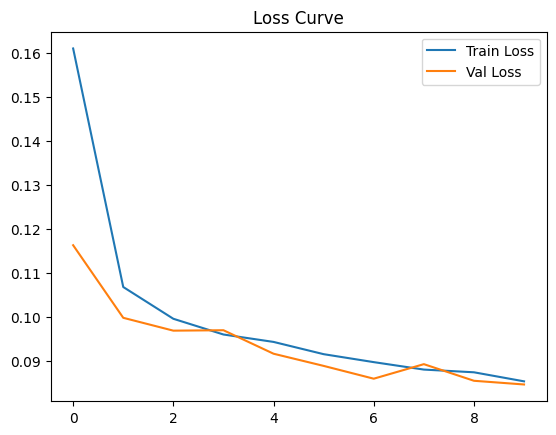

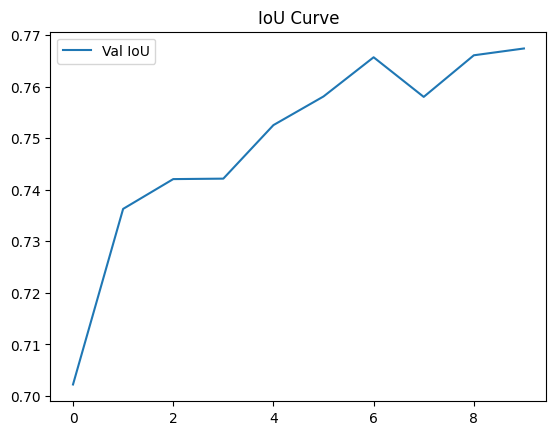

In [14]:
import matplotlib.pyplot as plt

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend(); plt.title("Loss Curve"); plt.show()
plt.plot(history["val_iou"], label="Val IoU")
plt.legend(); plt.title("IoU Curve"); plt.show()